# ECS171 Final Group Project: Pizza/Not Pizza Image Classifier


## Step 1: Data Exploration
Goals for this portion of the project:
+ Data evaluation
    + Evaluate all of the photos in the dataset, cull outliers
+ Number of total observations
    + Number and list of classes, plot class data
+ Image specifications
    + Total number of images
    + Image dimensions, and whether they need to be processed to be standardized

Preliminary data evaluation:
- The pizza directory also includes images of primarily people eating pizza (and one singular photo of a baby), and not the actual food itself; they've been culled before we imported the data.
- Data cannot be downloaded from Kaggle without an account; the data has been downloaded and stored in the GitHub repo instead to simplify the process of importing the repo and directly using this notebook, at the cost of storage space (however, the data is only ~100 MB unpacked).

In [60]:
# Library imports
# The standard ones.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Use the built-in Keras utilities for image imports
# The TensorFlow version will provide additional support
import tensorflow as tf
from tensorflow import keras

Found 1962 files belonging to 2 classes.


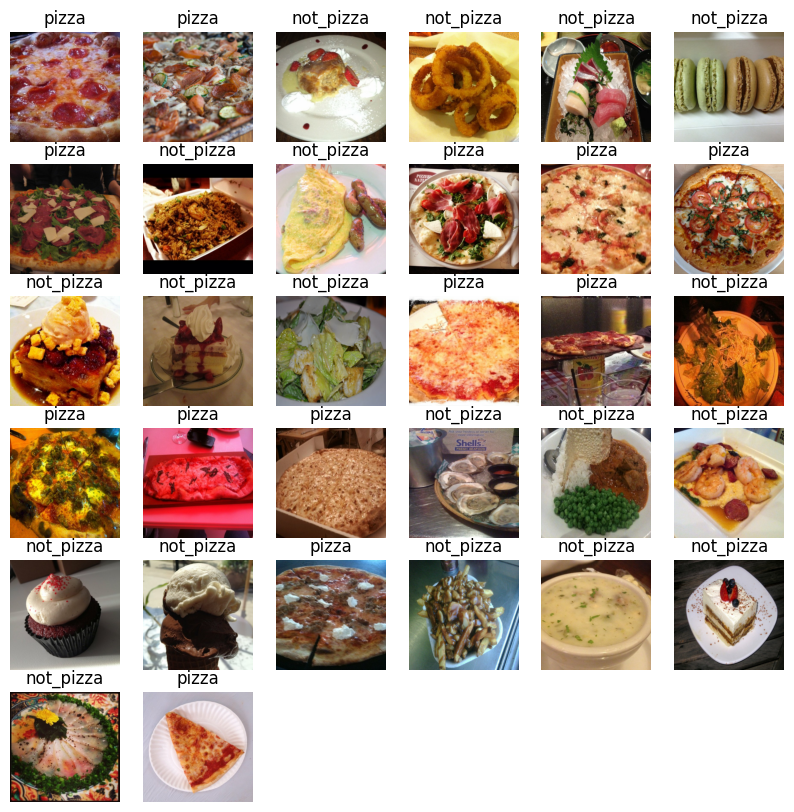

In [61]:
# Based on the docs, this will infer class type from directory structure.
# From the data directory, import the images with binary numeric labels and convert to RGB (f not already)
data = tf.keras.utils.image_dataset_from_directory("pizza_not_pizza", labels='inferred', label_mode='binary', color_mode='rgb')

# Following code is modified from https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data
plt.figure(figsize=(10, 10))
class_names = data.class_names
for images, labels in data.take(1):
    for i in range(32): # Batch size is default of 32
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")

Members of not_pizza: 983
Members of pizza: 979
Total # of classes: 2


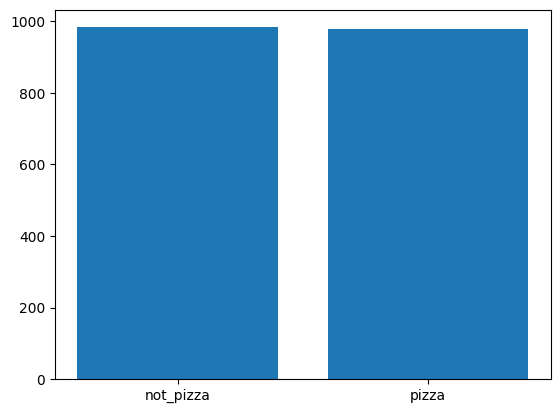

In [62]:
# Per the documents, there doesn't seem to be an easy way to get # of images per class from the dataset.
# Therefore, we can just do it ourselves the hard way — this solution assumes the OS library cannot be used.

plotLabel = [0, 0] # Not pizza, pizza
# Get all the file paths
fp = np.array(data.file_paths)
# Cull the parent directory from each string
fp = [i[16:] for i in fp]
for i in range(len(fp)):
    if fp[i].find("not_pizza") != -1:
        plotLabel[0] += 1
    else:
        plotLabel[1] += 1

plt.bar(class_names, plotLabel)
print("Members of " + class_names[0] + ": " + str(plotLabel[0]))
print("Members of " + class_names[1] + ": " + str(plotLabel[1]))
print("Total # of classes: " + str(len(class_names)))

### Image specifications
- Per the original dataset, there were 983 images of both pizza and non-pizza, meaning that the original set had a total of 1,966 photos. After our outlier check, there are now only 979 images of pizza, meaning we're currently working with 1,962 images. Furthermore, all provided photos have been resized such that one dimension of either width or height is 512 pixels, but wildly vary in the other dimension; the most consistent aspect ratio being square 1:1 photos. In this case, we can either choose to keep Keras' perservation of the full image with aspect ratio distortion, or enable cropping of the photo on import.

## Step 2: Pre-Processing
Goals for this portion of the project:
+ Image Processing
	+ Crop/resize all images to standard/downsampled size
	+ Pixel normalization/standardization for CNN input
	+ Image flattening(?)

Found 1962 files belonging to 2 classes.


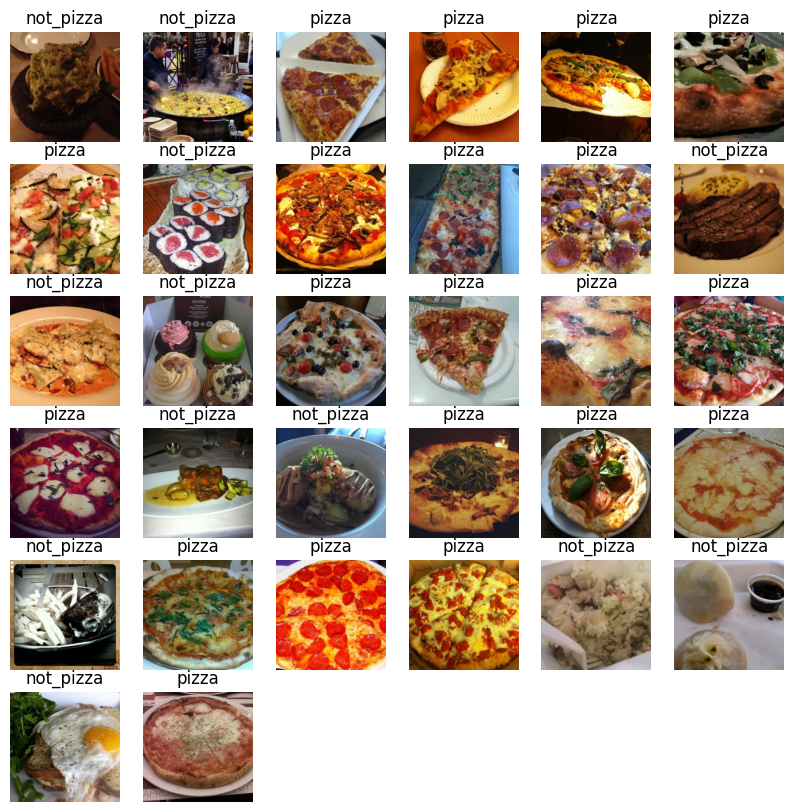

In [63]:
# We can perform point 1 by setting hyperparameter crop_to_aspect_ratio as true upon importing the data
# We can also resize by specifying the hyperparameter image_size, although this is done by default at 256x256
newData = tf.keras.utils.image_dataset_from_directory(
    "pizza_not_pizza",
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    crop_to_aspect_ratio = True)

plt.figure(figsize=(10, 10))
class_names = newData.class_names
for images, labels in newData.take(1):
    for i in range(32): # Batch size is default of 32
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")
        
# From the documents, we can implement a standardization layer in the model such that we don't have to pre-process beforehand
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

# Flattening does not seem strictly necessary if we simply create the model with the raw pictures per the documents

In [64]:
# Implement an 80/20 train/test split
# Important to note that this splits our batches, rather than the images themselves, cleanly in 80/20
train_data, test_data = tf.keras.utils.split_dataset(newData, left_size = 0.8, shuffle = True, seed = 21)
# Tune the datasets for performance optimization per the documentation
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)

## Step 3: Model Creation

Goals for this portion of the project:

+ Create models
	+ Split the data into training/testing batches
	+ Create a basic convolutional neural network via Keras
+ Evaluate the model's performance
	+ Comparison of training versus testing performance
	+ Evaluate fit against fitting graph
+ Choose most successful model, or tweak models to improve performance

### First Model
First attempt at implementation — a basic model with no real considerations.

In [65]:
from tensorflow.keras.models import Sequential

# For our first model, we'll try something like the models in the 
# TensorFlow docs + the basic convolutional model from HW2.
model = tf.keras.Sequential([
  normalization_layer, # The normalizer/standardizer layer from pre-processing section
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (256, 256, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# From the referenced Medium article, use the Adam optimizer 
# and binary cross-entropy, since we're making a binary classifier.
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

# Ten epochs due to the speed of training
trainHistory = model.fit(train_data, epochs = 10)

Epoch 1/10
50/50 [==============================] - 36s 712ms/step - loss: 1.2353 - accuracy: 0.5675
Epoch 2/10
50/50 [==============================] - 35s 703ms/step - loss: 0.6505 - accuracy: 0.6363
Epoch 3/10
50/50 [==============================] - 34s 675ms/step - loss: 0.5986 - accuracy: 0.6854
Epoch 4/10
50/50 [==============================] - 34s 677ms/step - loss: 0.5510 - accuracy: 0.7338
Epoch 5/10
50/50 [==============================] - 34s 674ms/step - loss: 0.4554 - accuracy: 0.7898
Epoch 6/10
50/50 [==============================] - 33s 653ms/step - loss: 0.3140 - accuracy: 0.8611
Epoch 7/10
50/50 [==============================] - 33s 656ms/step - loss: 0.2291 - accuracy: 0.9115
Epoch 8/10
50/50 [==============================] - 35s 693ms/step - loss: 0.1805 - accuracy: 0.9261
Epoch 9/10
50/50 [==============================] - 33s 665ms/step - loss: 0.1546 - accuracy: 0.9433
Epoch 10/10
50/50 [==============================] - 34s 678ms/step - loss: 0.1485 - accura

#### Evaluation

In [66]:
y_predTrain = [] # store predicted labels
y_trueTrain = [] # store true labels
y_predTest = []
y_trueTest = []

# Loop over the data, pull its true label and its predicted label into respective arrays
# Use verbose = 0 to surpress Keras output while we do this
for images, labels in train_data:
    y_trueTrain.append(np.where(labels > 0.5, 1, 0))
    y_predTrain.append(np.where(model.predict(images, verbose = 0) > 0.5, 1, 0))
for images, labels in test_data:
    y_trueTest.append(np.where(labels > 0.5, 1, 0))
    y_predTest.append(np.where(model.predict(images, verbose = 0) > 0.5, 1, 0))
    
# Concatenate the resulting arrays
y_predTrain = tf.concat(y_predTrain, axis=0)
y_trueTrain = tf.concat(y_trueTrain, axis=0)
y_predTest = tf.concat(y_predTest, axis=0)
y_trueTest = tf.concat(y_trueTest, axis=0)

Training Data

              precision    recall  f1-score   support

   Not Pizza       0.98      0.99      0.99       782
       Pizza       0.99      0.98      0.99       788

    accuracy                           0.99      1570
   macro avg       0.99      0.99      0.99      1570
weighted avg       0.99      0.99      0.99      1570



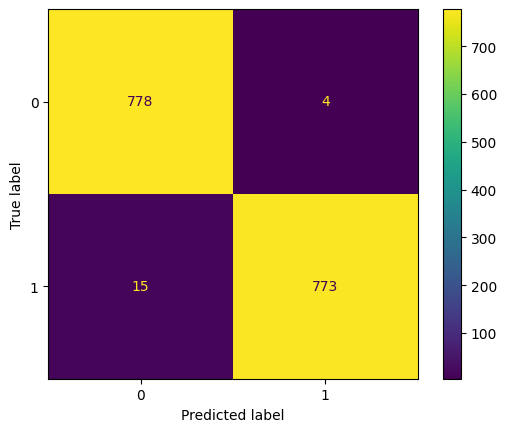

In [67]:
# Create confusion matrices and classification reports to visualize categorizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print("Training Data\n")
cm1 = confusion_matrix(y_trueTrain, y_predTrain)
cm_display1 = ConfusionMatrixDisplay(cm1).plot()
print(classification_report(y_trueTrain, y_predTrain, target_names = ["Not Pizza", "Pizza"]))

Testing Data

              precision    recall  f1-score   support

   Not Pizza       0.59      0.53      0.56       201
       Pizza       0.56      0.62      0.59       191

    accuracy                           0.57       392
   macro avg       0.58      0.58      0.57       392
weighted avg       0.58      0.57      0.57       392



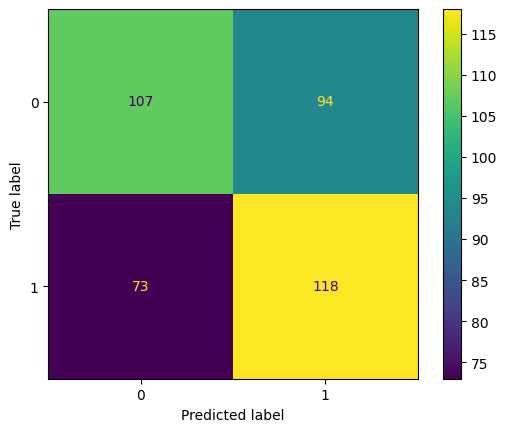

In [68]:
print("Testing Data\n")
cm2 = confusion_matrix(y_trueTest, y_predTest)
cm_display2 = ConfusionMatrixDisplay(cm2).plot()
print(classification_report(y_trueTest, y_predTest, target_names = ["Not Pizza", "Pizza"]))

In [69]:
# Use the evaluate function to evaluate how well our model does with training vs. testing data
# Accuracy should agree (to 0.1%) with that calculated for confusion matrices / classification reports
trainMetrics = model.evaluate(train_data, verbose = 0)
testMetrics = model.evaluate(test_data, verbose = 0)
print("Training data performance:\nLoss: %.2f\nAccuracy: %.2f\n" % (trainMetrics[0], trainMetrics[1]))
print("Testing data performance:\nLoss: %.2f\nAccuracy: %.2f" % (testMetrics[0], testMetrics[1]))

Training data performance:
Loss: 0.06
Accuracy: 0.99

Testing data performance:
Loss: 1.47
Accuracy: 0.57


### Second Model
Second model implementation. Photos are converted to greyscale instead and imported using Pandas/Numpy, and hidden layers are minimized.

In [70]:
from PIL import Image
from sklearn.model_selection import train_test_split
import os

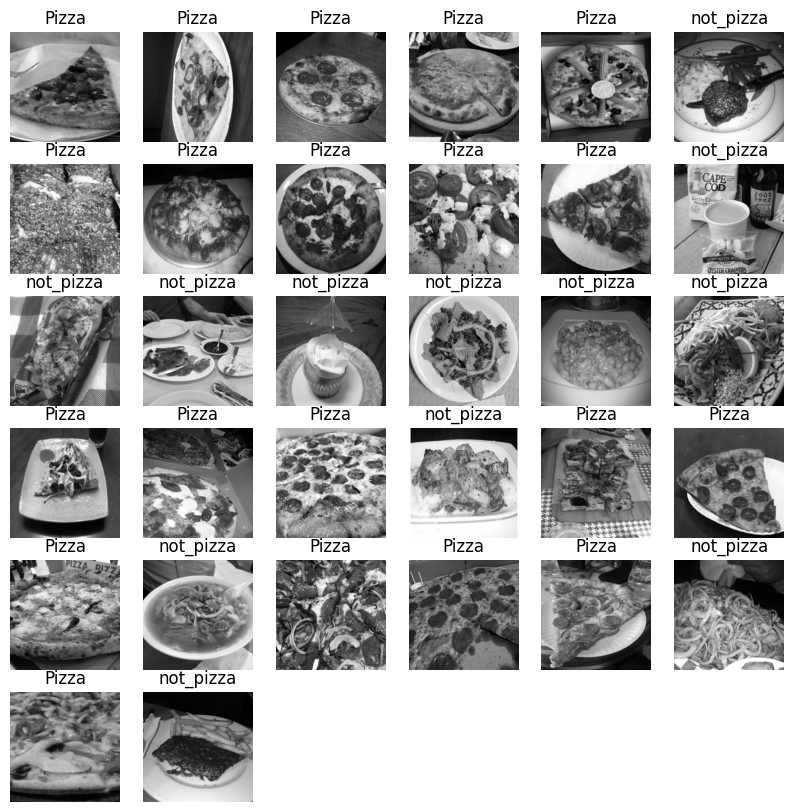

In [71]:
# Filepaths for the pizza and pasta images
fpath_pizza = "./pizza_not_pizza/pizza/"
fpath_notpizza = "./pizza_not_pizza/not_pizza/"
pizza_files = [fpath_pizza + file for file in os.listdir(fpath_pizza)]
notpizza_files = [fpath_notpizza + file for file in os.listdir(fpath_notpizza)]

# Construct pandas dataframe
df_pizza = pd.DataFrame()
df_pizza["filepath"] = pizza_files
df_pizza["label"] = np.zeros(len(pizza_files))

df_notpizza = pd.DataFrame()
df_notpizza["filepath"] = notpizza_files
df_notpizza["label"] = np.ones(len(notpizza_files))

df_data = pd.concat([df_pizza, df_notpizza])

# Function to load images
# Convert to grayscale (a float between 0-1) images and resize to 256x256 (default)
def load_images(filepath, size = (256, 256)):
    return np.asarray(Image.open(filepath).resize(size).convert('L')) / 255.0

# Split data into two df
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Plot examples
fig = plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(6, 6, i+1)
    img = load_images(df_train["filepath"][i])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if df_train["label"][i] == 0:
        plt.title("Pizza")
    else:
        plt.title("not_pizza")
plt.show()

In [72]:
# Create X_train, X_test, y_train, y_test
X_train = np.empty([df_train.shape[0], 256, 256])
for index, row in df_train.iterrows():
    img = load_images(row.filepath)
    X_train[index] = img
    
X_test = np.empty([df_test.shape[0], 256, 256])
for index, row in df_test.iterrows():
    img = load_images(row.filepath)
    X_test[index] = img

y_train = df_train["label"].to_numpy()
y_test = df_test["label"].to_numpy()

In [73]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(
  optimizer = keras.optimizers.Adam(),
  loss = keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

trainHistory2 = model2.fit(X_train, y_train, epochs = 10)

Epoch 1/10
50/50 [==============================] - 29s 562ms/step - loss: 2.5649 - accuracy: 0.5462
Epoch 2/10
50/50 [==============================] - 26s 521ms/step - loss: 0.5651 - accuracy: 0.6979
Epoch 3/10
50/50 [==============================] - 26s 528ms/step - loss: 0.3816 - accuracy: 0.8381
Epoch 4/10
50/50 [==============================] - 27s 541ms/step - loss: 0.3031 - accuracy: 0.8993
Epoch 5/10
50/50 [==============================] - 27s 533ms/step - loss: 0.1421 - accuracy: 0.9662
Epoch 6/10
50/50 [==============================] - 25s 510ms/step - loss: 0.0777 - accuracy: 0.9904
Epoch 7/10
50/50 [==============================] - 26s 512ms/step - loss: 0.0330 - accuracy: 0.9981
Epoch 8/10
50/50 [==============================] - 26s 516ms/step - loss: 0.0306 - accuracy: 0.9975
Epoch 9/10
50/50 [==============================] - 26s 526ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 10/10
50/50 [==============================] - 26s 511ms/step - loss: 0.0074 - accura

#### Evaluation

Training Data

              precision    recall  f1-score   support

   Not Pizza       1.00      1.00      1.00       794
       Pizza       1.00      1.00      1.00       775

    accuracy                           1.00      1569
   macro avg       1.00      1.00      1.00      1569
weighted avg       1.00      1.00      1.00      1569



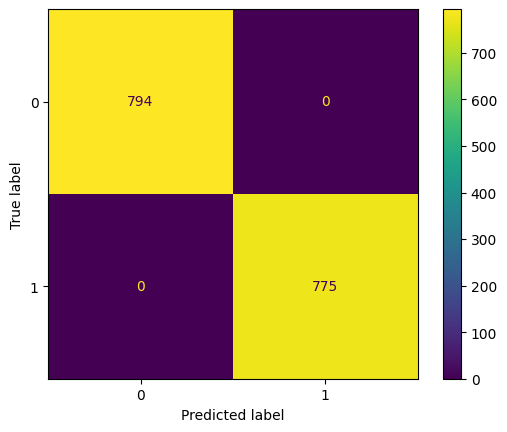

In [75]:
y_hat = model2.predict(X_train, verbose = 0)
y_hat = [ 1 if y>=0.5 else 0 for y in y_hat ]

print("Training Data\n")
cm3 = confusion_matrix(y_train, y_hat)
cm_display3 = ConfusionMatrixDisplay(cm3).plot()
print(classification_report(y_train, y_hat, target_names = ["Not Pizza", "Pizza"]))

Testing Data

              precision    recall  f1-score   support

   Not Pizza       0.70      0.79      0.74       185
       Pizza       0.79      0.69      0.74       208

    accuracy                           0.74       393
   macro avg       0.74      0.74      0.74       393
weighted avg       0.74      0.74      0.74       393



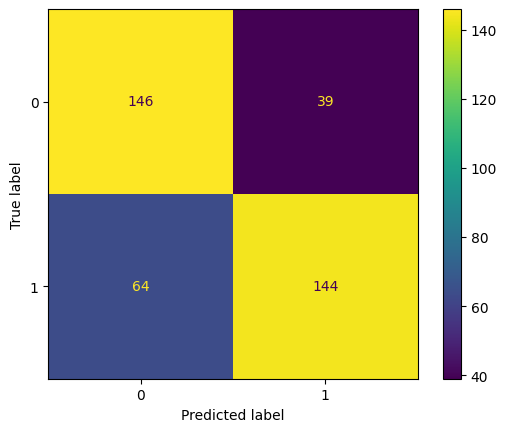

In [76]:
y_hat = model2.predict(X_test, verbose = 0)
y_hat = [ 1 if y>=0.5 else 0 for y in y_hat ]

print("Testing Data\n")
cm4 = confusion_matrix(y_test, y_hat)
cm_display4 = ConfusionMatrixDisplay(cm4).plot()
print(classification_report(y_test, y_hat, target_names = ["Not Pizza", "Pizza"]))

In [74]:
# Eval. accuracy should agree (to 0.1%) with that calculated for confusion matrices / classification reports
trainMetrics = model2.evaluate(X_train, y_train, verbose = 0)
testMetrics = model2.evaluate(X_test, y_test, verbose = 0)
print("Training data performance:\nLoss: %.2f\nAccuracy: %.2f\n" % (trainMetrics[0], trainMetrics[1]))
print("Testing data performance:\nLoss: %.2f\nAccuracy: %.2f" % (testMetrics[0], testMetrics[1]))

Training data performance:
Loss: 0.01
Accuracy: 1.00

Testing data performance:
Loss: 0.81
Accuracy: 0.74


### Third Model Implementation
Third model implementation. Combats overfitting by reducing number of neurons per layer, while introducing more hidden layers, including a dropout layer to limit influence of other layers — hence, we sacrifice some accuracy in the initial training run to gain more in the testing run.

In [77]:
model3 = tf.keras.Sequential([
  normalization_layer, # The normalizer/standardizer layer from pre-processing section
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (256, 256, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model3.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

trainHistory3 = model3.fit(train_data, batch_size=32, epochs = 10)

Epoch 1/10
50/50 [==============================] - 33s 647ms/step - loss: 0.6761 - accuracy: 0.5828
Epoch 2/10
50/50 [==============================] - 30s 608ms/step - loss: 0.6426 - accuracy: 0.6242
Epoch 3/10
50/50 [==============================] - 31s 610ms/step - loss: 0.6241 - accuracy: 0.6478
Epoch 4/10
50/50 [==============================] - 31s 610ms/step - loss: 0.6013 - accuracy: 0.6955
Epoch 5/10
50/50 [==============================] - 32s 639ms/step - loss: 0.6019 - accuracy: 0.6854
Epoch 6/10
50/50 [==============================] - 31s 620ms/step - loss: 0.5669 - accuracy: 0.7032
Epoch 7/10
50/50 [==============================] - 31s 618ms/step - loss: 0.5115 - accuracy: 0.7338
Epoch 8/10
50/50 [==============================] - 31s 616ms/step - loss: 0.4545 - accuracy: 0.7656
Epoch 9/10
50/50 [==============================] - 31s 621ms/step - loss: 0.3976 - accuracy: 0.8032
Epoch 10/10
50/50 [==============================] - 31s 617ms/step - loss: 0.3855 - accura

#### Evaluation

In [78]:
y3_predTrain = [] # store predicted labels
y3_trueTrain = [] # store true labels
y3_predTest = []
y3_trueTest = []

# Loop over the data, pull its true label and its predicted label into respective arrays
for images, labels in train_data:
    y3_trueTrain.append(np.where(labels > 0.5, 1, 0))
    y3_predTrain.append(np.where(model3.predict(images, verbose = 0) > 0.5, 1, 0))
for images, labels in test_data:
    y3_trueTest.append(np.where(labels > 0.5, 1, 0))
    y3_predTest.append(np.where(model3.predict(images, verbose = 0) > 0.5, 1, 0))
    
# Concatenate the resulting arrays
y3_predTrain = tf.concat(y3_predTrain, axis=0)
y3_trueTrain = tf.concat(y3_trueTrain, axis=0)
y3_predTest = tf.concat(y3_predTest, axis=0)
y3_trueTest = tf.concat(y3_trueTest, axis=0)

Training Data

              precision    recall  f1-score   support

   Not Pizza       0.91      0.89      0.90       782
       Pizza       0.89      0.91      0.90       788

    accuracy                           0.90      1570
   macro avg       0.90      0.90      0.90      1570
weighted avg       0.90      0.90      0.90      1570



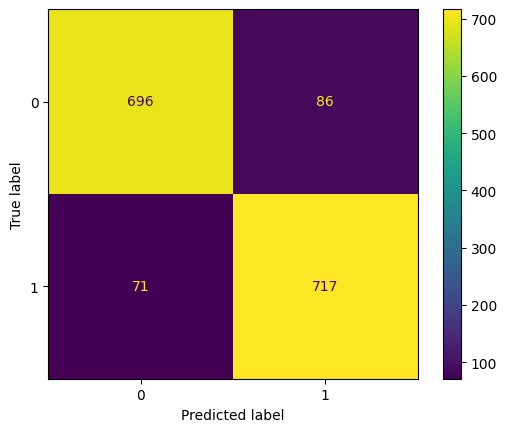

In [79]:
print("Training Data\n")
cm5 = confusion_matrix(y3_trueTrain, y3_predTrain)
cm_display5 = ConfusionMatrixDisplay(cm5).plot()
print(classification_report(y3_trueTrain, y3_predTrain, target_names = ["Not Pizza", "Pizza"]))

Testing Data

              precision    recall  f1-score   support

   Not Pizza       0.76      0.68      0.72       201
       Pizza       0.70      0.77      0.73       191

    accuracy                           0.73       392
   macro avg       0.73      0.73      0.73       392
weighted avg       0.73      0.73      0.73       392



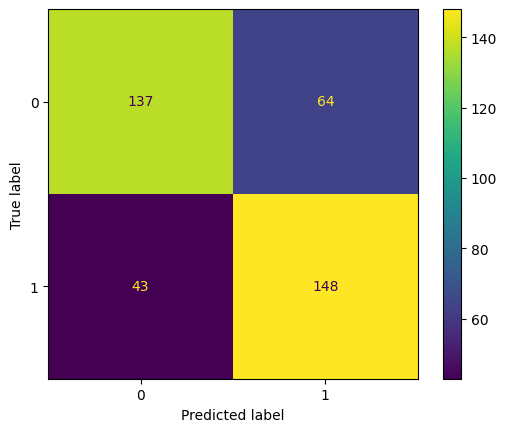

In [80]:
print("Testing Data\n")
cm6 = confusion_matrix(y3_trueTest, y3_predTest)
cm_display6 = ConfusionMatrixDisplay(cm6).plot()
print(classification_report(y3_trueTest, y3_predTest, target_names = ["Not Pizza", "Pizza"]))

In [81]:
# Eval. accuracy should agree (to 0.1%) with that calculated for confusion matrices / classification reports
trainMetrics = model3.evaluate(train_data, verbose = 0)
testMetrics = model3.evaluate(test_data, verbose = 0)
print("Training data performance:\nLoss: %.2f\nAccuracy: %.2f\n" % (trainMetrics[0], trainMetrics[1]))
print("Testing data performance:\nLoss: %.2f\nAccuracy: %.2f" % (testMetrics[0], testMetrics[1]))

Training data performance:
Loss: 0.26
Accuracy: 0.90

Testing data performance:
Loss: 0.55
Accuracy: 0.73


### Fourth Model Pass
Fourth model implementation. Attempts to try to combat overfitting via simplification by reducing almost everything: layer count, node count, convolution and MaxPooling area, and even image size (down to 64x64). This also comes with the added benefit of training being much faster than previous models.

Found 1962 files belonging to 2 classes.


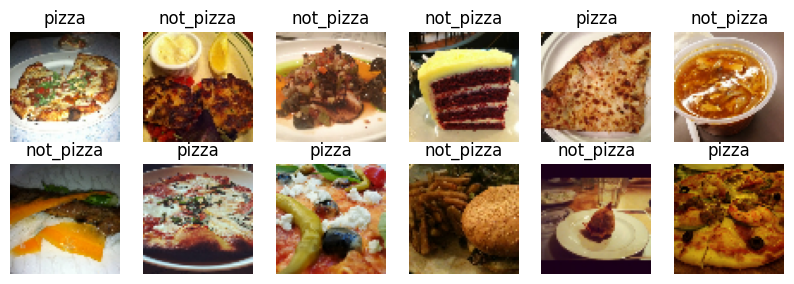

In [96]:
# This time, crop images to 64x64
finalData = tf.keras.utils.image_dataset_from_directory(
    "pizza_not_pizza",
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    image_size=(64, 64),
    crop_to_aspect_ratio=True)

plt.figure(figsize=(10, 10))
class_names = finalData.class_names
for images, labels in finalData.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")

# New normalization layer
normalization_layer_64 = layers.Rescaling(1./63)

# Implement an 80/20 train/test split
train_fData, test_fData = tf.keras.utils.split_dataset(finalData, left_size = 0.8, shuffle = True, seed = 21)

# Tune the datasets for performance optimization
train_fData = train_fData.cache().prefetch(buffer_size = AUTOTUNE)
test_fData = test_fData.cache().prefetch(buffer_size = AUTOTUNE)

In [100]:
# Build and train model
modelF = tf.keras.Sequential([
    normalization_layer_64,
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.MaxPooling2D((8, 8)),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

modelF.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

trainHistoryF = modelF.fit(train_fData, epochs = 10)

Epoch 1/10
50/50 [==============================] - 1s 17ms/step - loss: 0.6687 - accuracy: 0.5854
Epoch 2/10
50/50 [==============================] - 1s 17ms/step - loss: 0.5579 - accuracy: 0.7204
Epoch 3/10
50/50 [==============================] - 1s 16ms/step - loss: 0.5306 - accuracy: 0.7287
Epoch 4/10
50/50 [==============================] - 1s 17ms/step - loss: 0.5070 - accuracy: 0.7605
Epoch 5/10
50/50 [==============================] - 1s 16ms/step - loss: 0.4844 - accuracy: 0.7828
Epoch 6/10
50/50 [==============================] - 1s 16ms/step - loss: 0.4568 - accuracy: 0.7987
Epoch 7/10
50/50 [==============================] - 1s 16ms/step - loss: 0.4250 - accuracy: 0.8057
Epoch 8/10
50/50 [==============================] - 1s 15ms/step - loss: 0.4164 - accuracy: 0.8210
Epoch 9/10
50/50 [==============================] - 1s 16ms/step - loss: 0.4093 - accuracy: 0.8166
Epoch 10/10
50/50 [==============================] - 1s 16ms/step - loss: 0.3742 - accuracy: 0.8420


#### Evaluation

In [114]:
yF_predTrain = [] # store predicted labels
yF_trueTrain = [] # store true labels
yF_predTest = []
yF_trueTest = []

# Loop over the data, pull its true label and its predicted label into respective arrays
for images, labels in train_fData:
    yF_trueTrain.append(np.where(labels > 0.5, 1, 0))
    yF_predTrain.append(np.where(modelF.predict(images, verbose = 0) > 0.5, 1, 0))
for images, labels in test_fData:
    yF_trueTest.append(np.where(labels > 0.5, 1, 0))
    yF_predTest.append(np.where(modelF.predict(images, verbose = 0) > 0.5, 1, 0))
    
# Concatenate the resulting arrays
yF_predTrain = tf.concat(yF_predTrain, axis=0)
yF_trueTrain = tf.concat(yF_trueTrain, axis=0)
yF_predTest = tf.concat(yF_predTest, axis=0)
yF_trueTest = tf.concat(yF_trueTest, axis=0)

Training Data

              precision    recall  f1-score   support

   Not Pizza       0.94      0.78      0.85       781
       Pizza       0.82      0.95      0.88       789

    accuracy                           0.87      1570
   macro avg       0.88      0.87      0.86      1570
weighted avg       0.88      0.87      0.86      1570



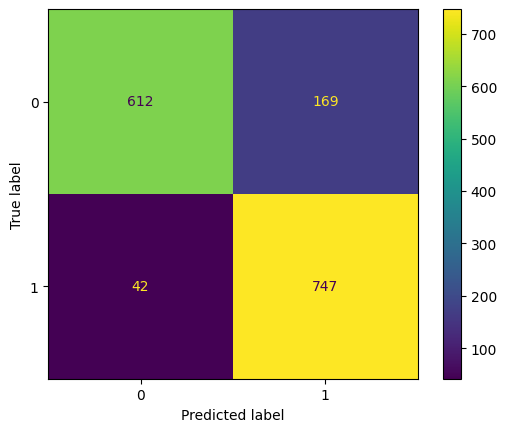

In [115]:
print("Training Data\n")
cm7 = confusion_matrix(yF_trueTrain, yF_predTrain)
cm_display7 = ConfusionMatrixDisplay(cm7).plot()
print(classification_report(yF_trueTrain, yF_predTrain, target_names = ["Not Pizza", "Pizza"]))

Testing Data

              precision    recall  f1-score   support

   Not Pizza       0.87      0.72      0.79       202
       Pizza       0.75      0.88      0.81       190

    accuracy                           0.80       392
   macro avg       0.81      0.80      0.80       392
weighted avg       0.81      0.80      0.80       392



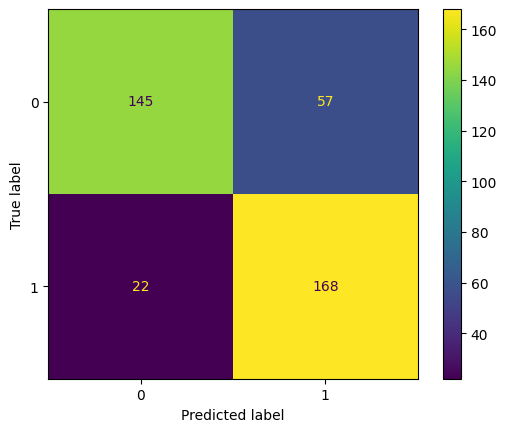

In [116]:
print("Testing Data\n")
cm8 = confusion_matrix(yF_trueTest, yF_predTest)
cm_display8 = ConfusionMatrixDisplay(cm8).plot()
print(classification_report(yF_trueTest, yF_predTest, target_names = ["Not Pizza", "Pizza"]))

In [117]:
# Evaluate model
trainMetrics = modelF.evaluate(train_fData, verbose = 0)
testMetrics = modelF.evaluate(test_fData, verbose = 0)
print("Training data performance:\nLoss: %.2f\nAccuracy: %.2f\n" % (trainMetrics[0], trainMetrics[1]))
print("Testing data performance:\nLoss: %.2f\nAccuracy: %.2f" % (testMetrics[0], testMetrics[1]))

Training data performance:
Loss: 0.33
Accuracy: 0.87

Testing data performance:
Loss: 0.46
Accuracy: 0.80


### Model Fit Evaluation
![Model complexity graph](notebook_resources/model-fit-graph.png)

+ For model 1 (initial), based on the high loss and low accuracy of the testing data in comparison to the low loss and high accuracy of the training data, we can very safely say that our model is overfit to the training data, and is thus skewed towards the right-most end of the model complexity graph. 
+ For models 2 (greyscale) and 3 (overfit trial), since our accuracy is higher by a decent percentage with regards to testing data, the models move more towards the center of the graph, but are still skewed towards the right.
+ For model 4 (simplicity), due to relatively high accuracy in both training and testing, and the overall simplicity of the model in comparison, this model trends the most towards the middle/left by comparison to the remaining three.

### References used in model programming
+ https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb
+ https://www.researchgate.net/figure/Model-complexity-and-prediction-error_fig1_339913183
+ https://stackoverflow.com/a/68927032
+ https://stackoverflow.com/a/73215222